In [1]:
# import os

# os.environ["OPENAI_API_KEY"] = ""

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_id: int
    user_info: str

In [3]:
from langchain_core.tools import tool

@tool
def get_user_info(user_id: int) -> dict:
    """
    Get user information by user id.

    Args:
        user_id (int)

    Returns:
        dict: User information
    """
    user = {}
    user["user_id"] = str(user_id)
    user["name"] = "John Doe"
    user["email"] = "john@mail.com"
    return user

@tool
def get_user_orders(user_id: int) -> list[dict]:
    """
    Get user order list by user id.

    Args:
        user_id (int)

    Returns:
        list[dict]: A list of orders that belong to user
    """
    order_1 = {}
    order_1["order_number"] = "NN-001"
    order_1["price"] = 100
    order_1["status"] = "ready_to_ship"
    order_1["sale_orders_id"] = ["12001", "12002"]

    order_2 = {}
    order_2["order_number"] = "NN-002"
    order_2["price"] = 200
    order_2["status"] = "payment_pending"
    order_2["sale_orders_id"] = ["12003", "12004"]
    return [order_1, 
    order_2]

@tool
def get_order_detail(user_id: int, order_number: str) -> dict:
    """
    Get order detail by order number.

    Args:
        order_number (str)

    Returns:
        dict: Order detail
    """
    if user_id != 1 or order_number != "NN-002":
        return "Order not found"
    order = {}
    order["order_number"] = "NN-002"
    order["price"] = 200
    order["status"] = "payment_pending"
    order["sale_orders_id"] = ["12003", "12004"]
    order["created_on"] = "2021-09-01"
    order["updated_on"] = "2021-09-02"
    return order

@tool
def cancel_user_order(user_id: int, order_number: str) -> str:
    """
    Cancel user order by user id and order number.

    Args:
        user_id (int)
        order_number (str)

    Returns:
        bool: True if order is cancelled successfully
    """
    return f"Order {order_number} is cancelled successfully"


In [4]:
# Define helper functions to pretty print the messages in the graph 
# while we debug it and to give our tool node error handling 
# (by adding the error to the chat history).
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [5]:
# Define LLM

# # Ollama does not support bind_tools yet.
# from langchain_community.chat_models import ChatOllama

# llm = ChatOllama(model="llama3")

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo")

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

In [7]:
from langchain_core.pydantic_v1 import BaseModel, Field

class ToCancelOrderWorkflow(BaseModel):
    """Start cancel order workflow."""

    order_number: str = Field(
        description="Order number of the order user want to cancel."
    )

In [8]:
from datetime import date, datetime

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for E-Commerce platform. "
            "Use the provided tools to help the user get their user information. "
            "If customer wants to cancel an order, call function ToCancelOrderWorkflow. "
            "If there are multiple orders mentioned, ask the user which order they want to proceed. "
            "You will answer in Thai language and address user by their name."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

safe_tools = [get_user_orders,
              get_order_detail,
              get_user_info]

assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    safe_tools + [ToCancelOrderWorkflow])

class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the user's emails or calendar for more information.",
            },
        }

In [9]:
from datetime import date, datetime

cancel_order_assistant = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for E-Commerce platform. "
            "Use the provided tools to help the user to cancel their order. "
            "You will answer in Thai language and address user by their name."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>",
        ),
        ("placeholder", "{messages}"),
    ]
)

confirmation_required_tools = [cancel_user_order]
confirmation_required_tools_names = {t.name for t in confirmation_required_tools}

cancel_order_assistant_runnable = cancel_order_assistant | llm.bind_tools(
    confirmation_required_tools)

In [10]:
from typing import Callable

from langchain_core.messages import ToolMessage


def create_workflow_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool."
                    # " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

In [11]:
from typing import Literal
from langgraph.prebuilt import tools_condition
from langgraph.graph import END

# function to keep only n last messages
def remove_previous_messages(state: State, number_of_keep: int) -> State:
    state["messages"] = state["messages"][-number_of_keep:]
    return state

def main_route_tools(state: State) -> Literal["safe_tools", "enter_cancel_order_workflow", "__end__"]:
    next_node = tools_condition(state)
    # If no tools are invoked, return to the user
    if next_node == END:
        return END
    ai_message = state["messages"][-1]
    # This assumes single tool calls. To handle parallel tool calling, 
    # you'd want to use an ANY condition
    first_tool_call = ai_message.tool_calls[0]
    if first_tool_call["name"] == ToCancelOrderWorkflow.__name__:
        state = remove_previous_messages(state, 1)
        return "enter_cancel_order_workflow"
    return "safe_tools"

def cancel_order_route_tools(state: State) -> Literal["cancel_order", "__end__"]:
    next_node = tools_condition(state)
    # If no tools are invoked, return to the user
    if next_node == END:
        return END
    ai_message = state["messages"][-1]
    # This assumes single tool calls. To handle parallel tool calling, 
    # you'd want to use an ANY condition
    first_tool_call = ai_message.tool_calls[0]
    if first_tool_call["name"] in [t.name for t in [cancel_user_order]]:
        return "cancel_order"
    return "__end__"

In [12]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.runnables import ensure_config

builder = StateGraph(State)

def get_user_info_action(state: State):
    config = ensure_config()  # Fetch from the context
    user_id = config.get("user_id", None)
    state = {**state, "user_id": user_id}
    return {"user_info": get_user_info.invoke({"user_id": user_id})}

# Sub workflow to cancel order
builder.add_node("enter_cancel_order_workflow", 
                 create_workflow_entry_node("cancel order assistant", "cancel_order_workflow"))
builder.add_node("cancel_order_workflow", Assistant(cancel_order_assistant_runnable))
builder.add_edge("enter_cancel_order_workflow", "cancel_order_workflow")
builder.add_node("cancel_order", create_tool_node_with_fallback(confirmation_required_tools))
builder.add_conditional_edges("cancel_order_workflow", 
                              cancel_order_route_tools)

# Define nodes: these do the work
builder.add_node("get_user_info", get_user_info_action)
builder.set_entry_point("get_user_info")
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("safe_tools", create_tool_node_with_fallback(safe_tools))
builder.add_edge("get_user_info", "assistant")
builder.add_conditional_edges(
    "assistant",
    main_route_tools,
)
builder.add_edge("safe_tools", "assistant")
builder.add_edge("cancel_order", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
graph = builder.compile(
    checkpointer=memory,
    # interrupt_before=["cancel_order"],
    )

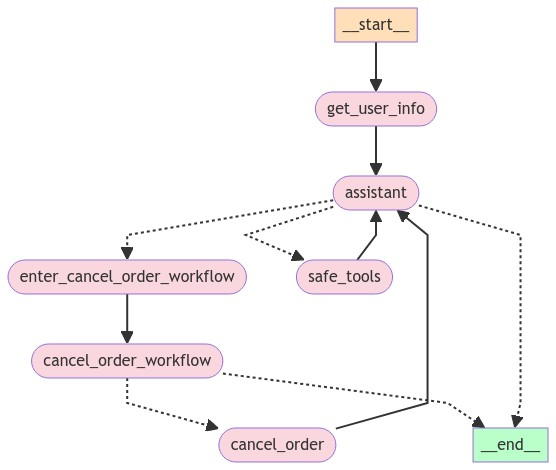

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)
    pass

In [14]:
import uuid
thread_id = str(uuid.uuid4())

config = RunnableConfig(
    configurable={
        "user_id": 1, 
        "thread_id": thread_id})
config.setdefault("user_id", 1)
config.setdefault("thread_id", thread_id)

_printed = set()
events = graph.stream(
    {"messages": ("user", "อยากรู้สถานะคำสั่งซื้อ?")}, 
    config, 
    stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

events = graph.stream(
    {"messages": ("user", "อยากยกเลิกคำสั่งซื้อ")}, 
    config, 
    stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

================================ Human Message =================================

อยากรู้สถานะคำสั่งซื้อ?


AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************Oqiv. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

In [30]:
events = graph.stream(
    {"messages": ("user", "NN-002")}, 
    config, 
    stream_mode="values"
)
for event in events:
    _print_event(event, _printed)
    snapshot = graph.get_state(config)

================================ Human Message =================================

NN-002
================================== Ai Message ==================================
Tool Calls:
  ToCancelOrderWorkflow (call_2omqy699JB1XZOCQcj6TanUN)
 Call ID: call_2omqy699JB1XZOCQcj6TanUN
  Args:
    order_number: NN-002
================================= Tool Message =================================

The assistant is now the cancel order assistant. Reflect on the above conversation between the host assistant and the user. The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are cancel order assistant, and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool. Do not mention who you are - just act as the proxy for the assistant.
================================== Ai Message ==================================
Tool Calls:
  cancel_user_order (call_eQyAA5euddxN7xV8ddLNDVYb)
 Call ID: call_eQyAA5eudd

In [ ]:
events = graph.stream(
    {"messages": ("user", "I like to cancel the order")}, 
    config, 
    stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

In [ ]:
result = graph.invoke(
                None,
                config,
            )